In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import const as CONST
from utils import read_csv_ts
from darts import TimeSeries
import matplotlib
from datasets import SeqDataset, Datasets, DatasetAccesor, DatasetTransformer, load_datasets
import seaborn as sns

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (20, 10)
COLORS = [
    "red", "green", "blue", "purple", "cyan", "olive", "gray", "brown", "pink",
]

In [2]:
ds = load_datasets()

INFO:Dataset:Loading dataset from data/preprocessed/datasets_hourly.pkl


In [3]:
print(f"Data starts: {ds.original.series[0].start_time()}")
print(f"Data ends: {ds.original.series[0].end_time()}, len = {len(ds.original.series[0])}")
print(f"Train data starts: {ds.original.train[0].start_time()}, len = {len(ds.original.train[0])}")
print(f"Validation data starts: {ds.original.val[0].start_time()}, len = {len(ds.original.val[0])}")
print(f"Test data starts: {ds.original.test[0].start_time()}, len = {len(ds.original.test[0])}")

Data starts: 2008-01-02 09:00:00
Data ends: 2023-03-09 16:00:00, len = 30584
Train data starts: 2008-01-02 09:00:00, len = 24467
Validation data starts: 2020-02-26 12:00:00, len = 3058
Test data starts: 2021-08-31 14:00:00, len = 3059


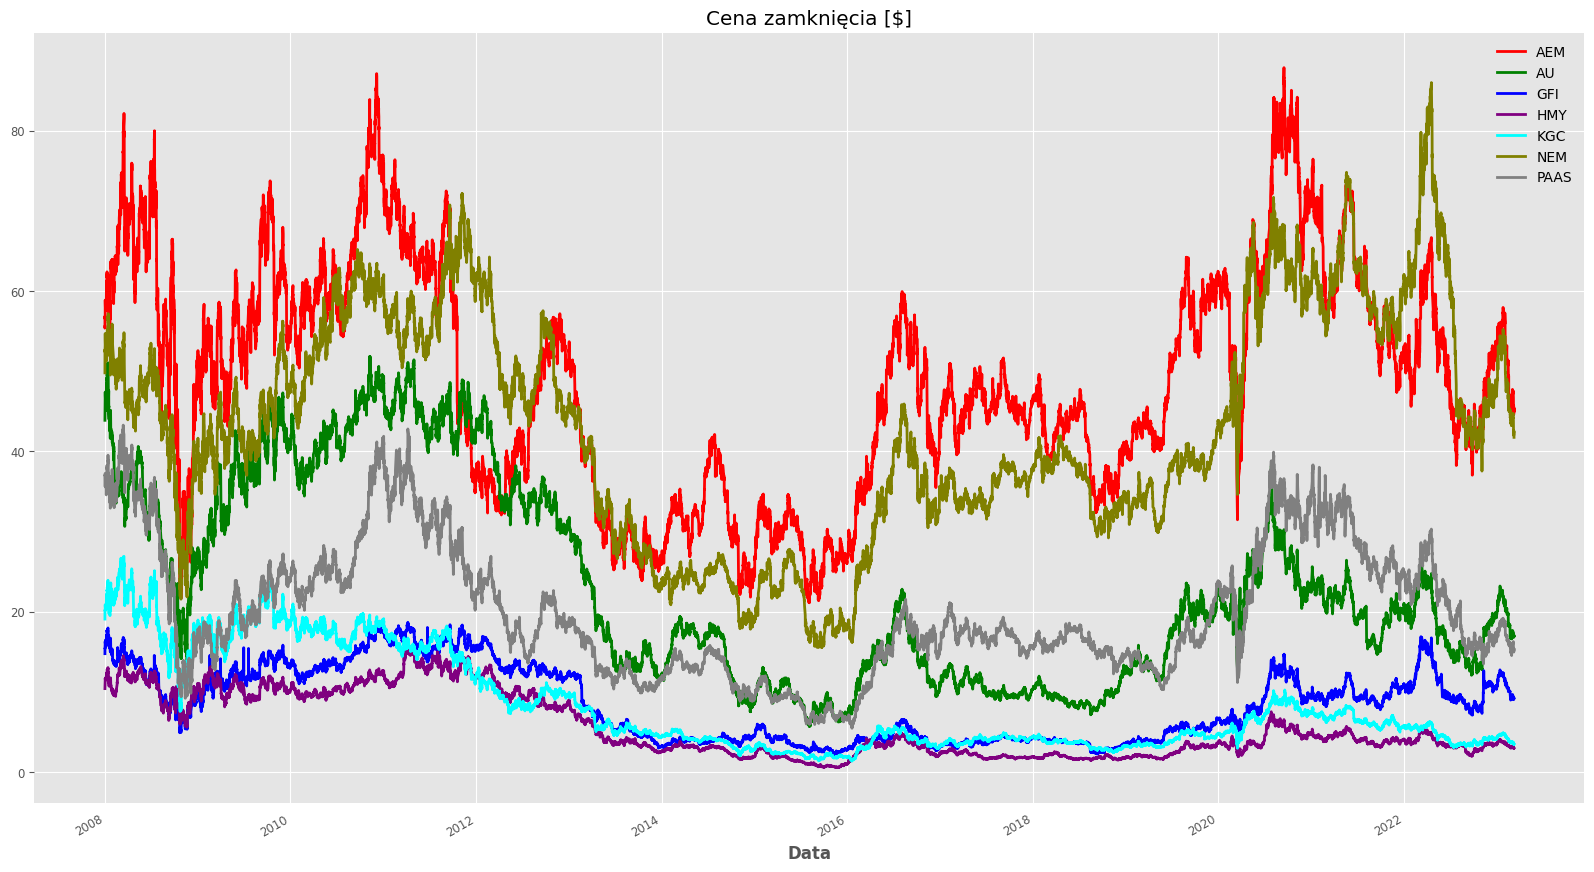

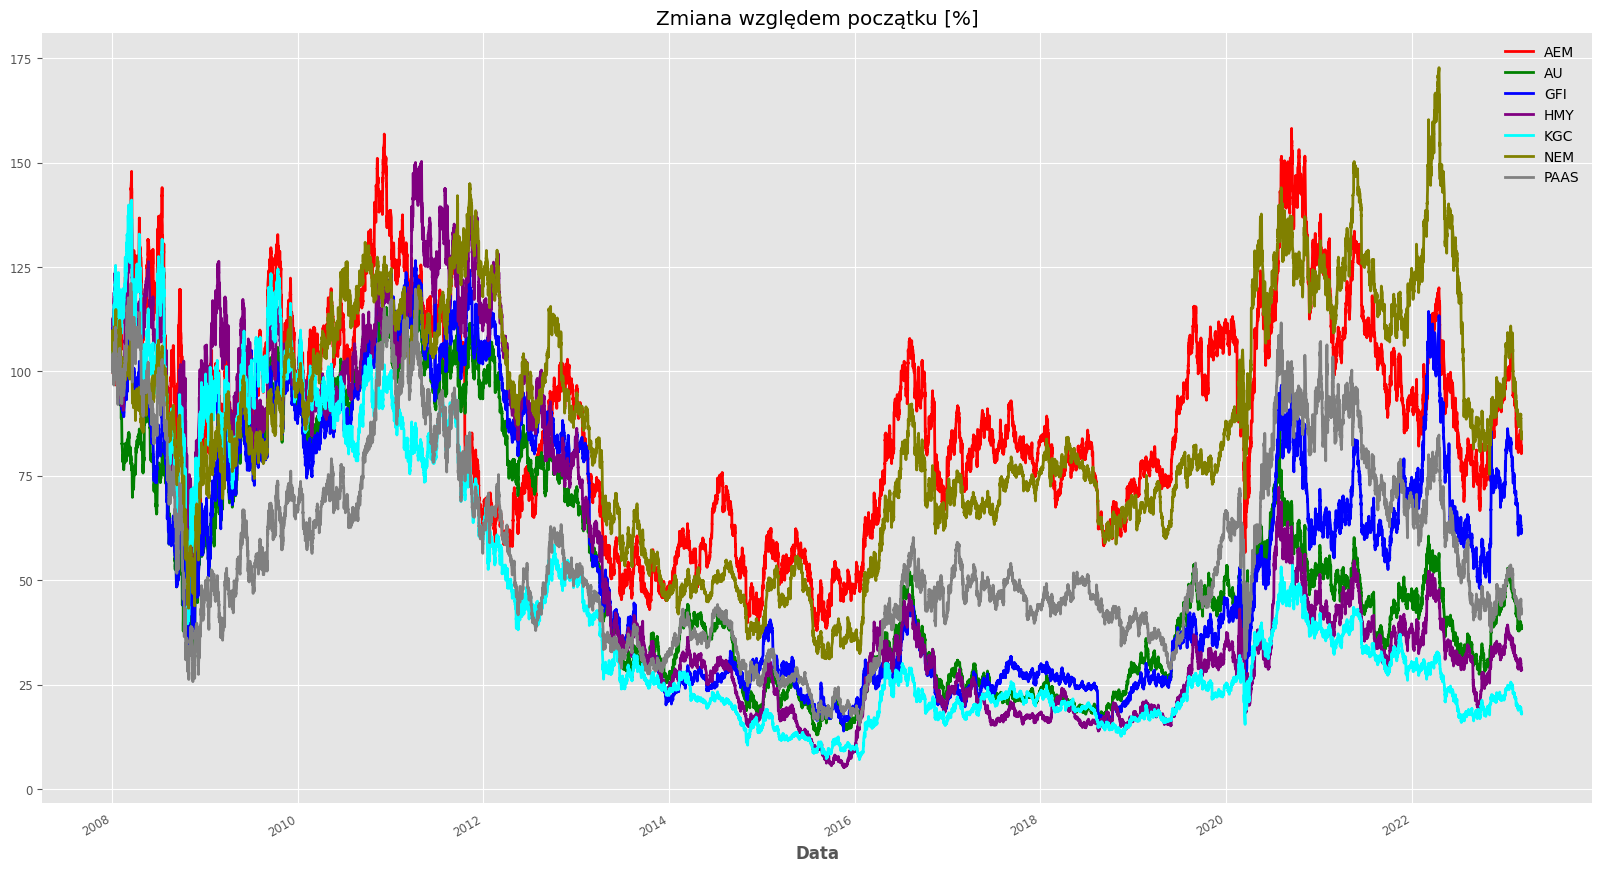

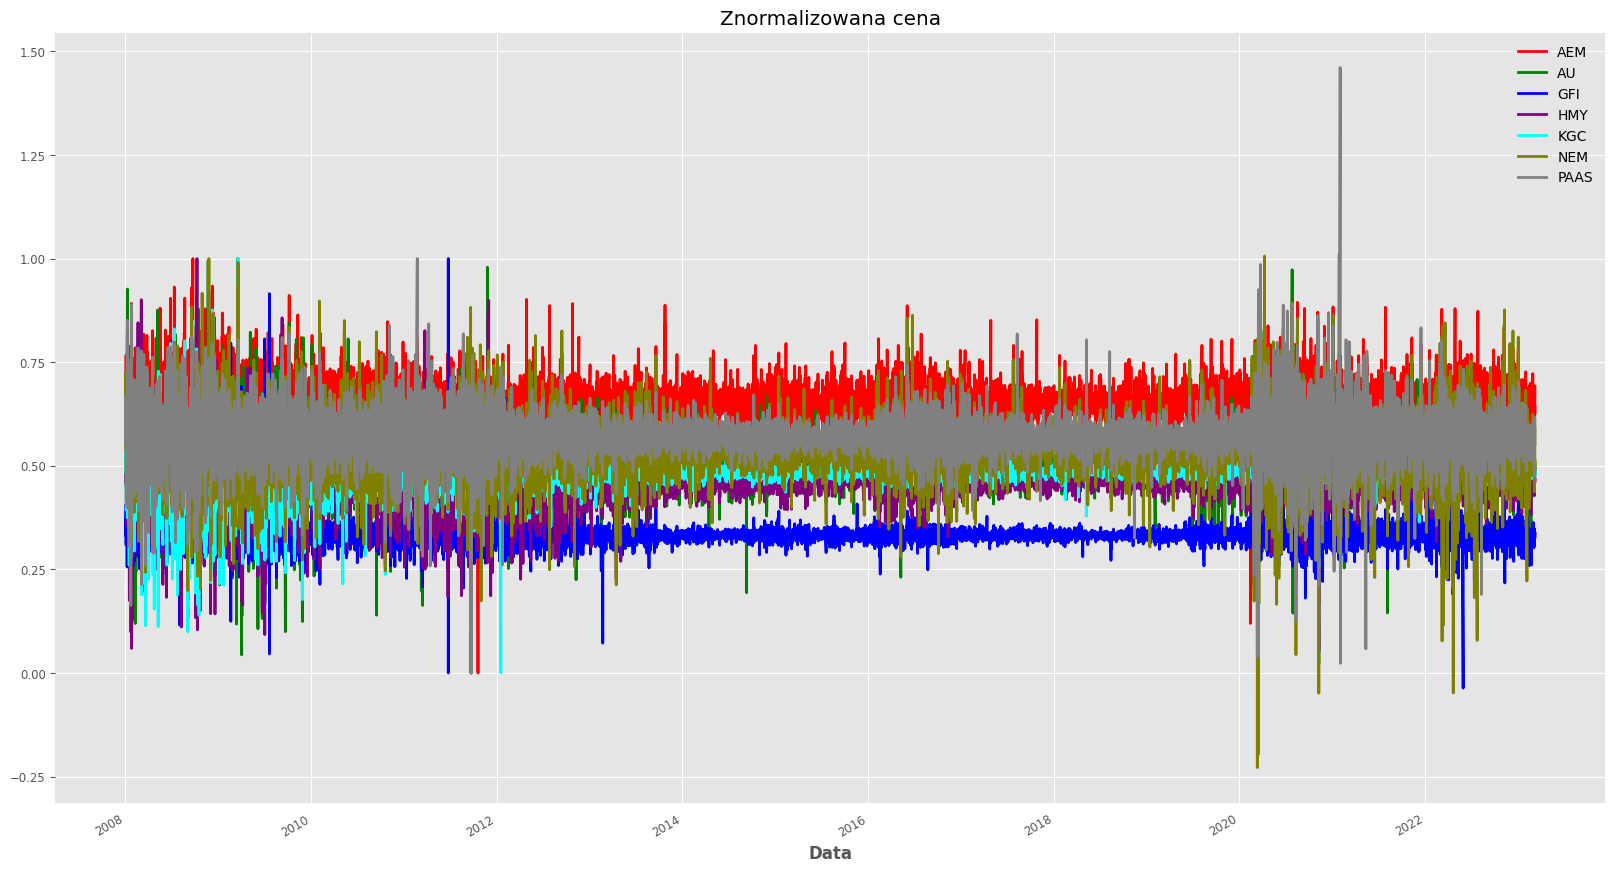

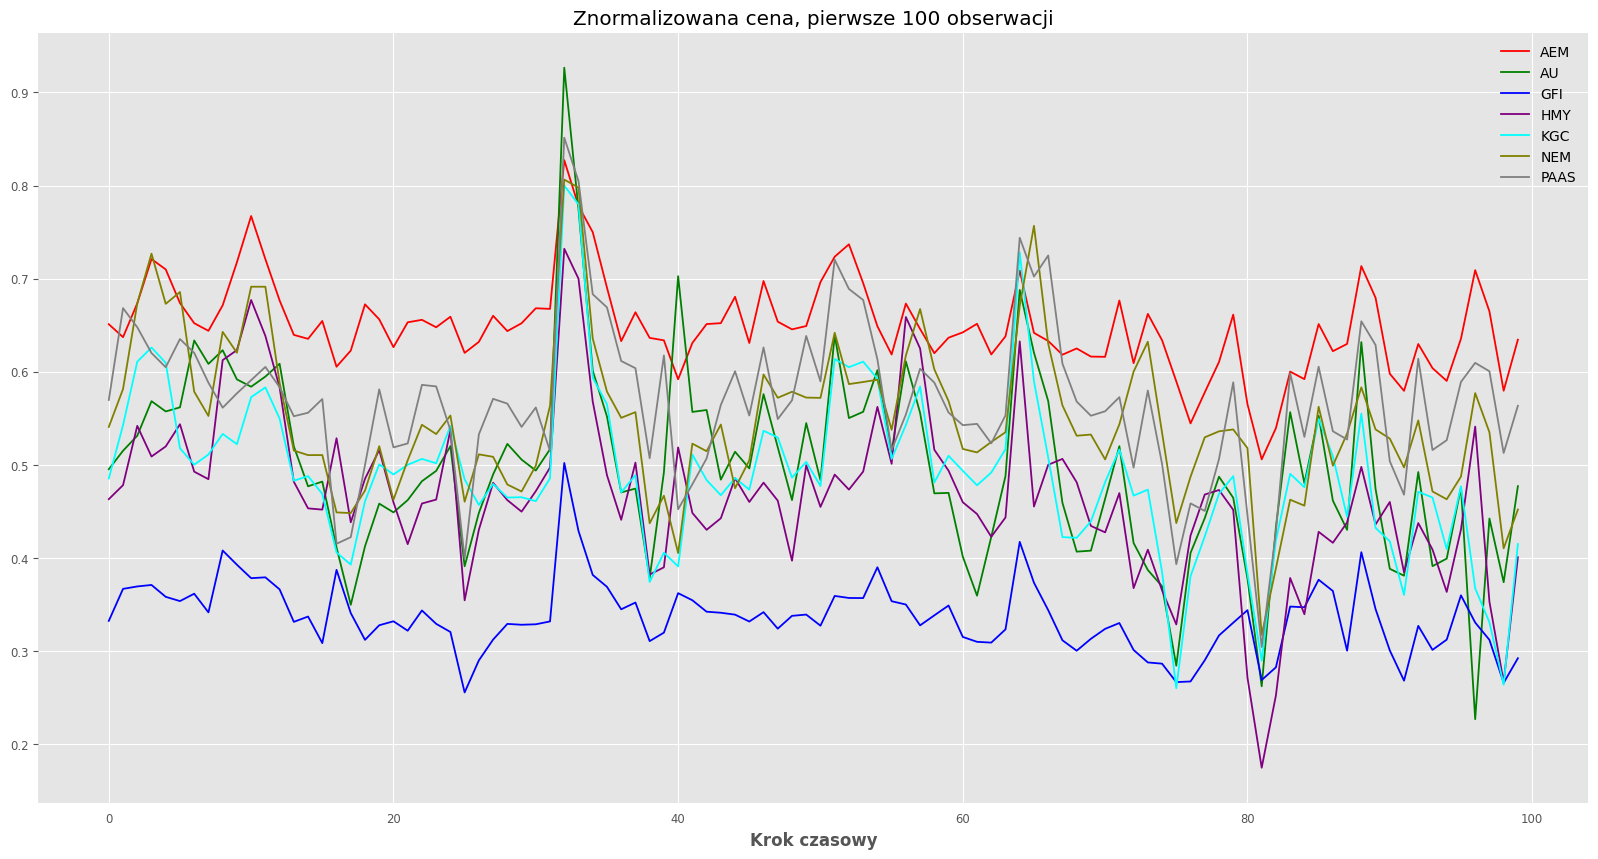

In [4]:
for idx,ticker in enumerate(ds.original.used_tickers):
    ds.original.series[idx].plot(label=ticker,color = COLORS[idx])

plt.title("Cena zamknięcia [$]")
plt.xlabel("Data")
plt.show()

for idx,ticker in enumerate(ds.original.used_tickers):
    (100* ds.original.series[idx]/ ds.original.series[idx].first_value()).plot(label=ticker, color = COLORS[idx])
plt.title("Zmiana względem początku [%]")
plt.xlabel("Data")
plt.show()

for idx,ticker in enumerate(ds.original.used_tickers):
    ds.transformed.series[idx].plot(label=ticker,color = COLORS[idx])
plt.title("Znormalizowana cena")
plt.xlabel("Data")
plt.show()


for idx,ticker in enumerate(ds.original.used_tickers):
    plt.plot(ds.transformed.series[idx][0:100].values(),label=ticker,color = COLORS[idx])
plt.legend(ds.original.used_tickers)
plt.title("Znormalizowana cena, pierwsze 100 obserwacji")
plt.xlabel("Krok czasowy")
plt.show()

In [5]:
my_dict = dict(zip(CONST.TICKERS,[x.pd_series().pct_change().values[1:] * 100 for x in ds.original.train]))
df = pd.DataFrame(my_dict)
df.describe()

,AEM,AU,GFI,HMY,KGC,NEM,PAAS
count,24466.000000,24466.000000,24466.000000,24466.000000,24466.000000,24466.000000,24466.000000
mean,0.004151,0.002192,0.004064,0.003113,0.000776,0.002916,0.003281
std,0.946113,1.017342,1.186424,1.182680,1.061178,0.766847,0.986884
min,-15.675235,-12.337798,-23.321527,-9.463650,-15.222806,-7.575572,-11.274618
25%,-0.351882,-0.374077,-0.417519,-0.483902,-0.431307,-0.298434,-0.404149
50%,0.002360,0.000364,0.000000,-0.006127,-0.011340,0.000042,-0.001597
75%,0.349981,0.357613,0.406346,0.450861,0.414792,0.293782,0.394672
max,12.141096,22.563231,30.232525,14.083635,12.148285,8.653868,12.201130


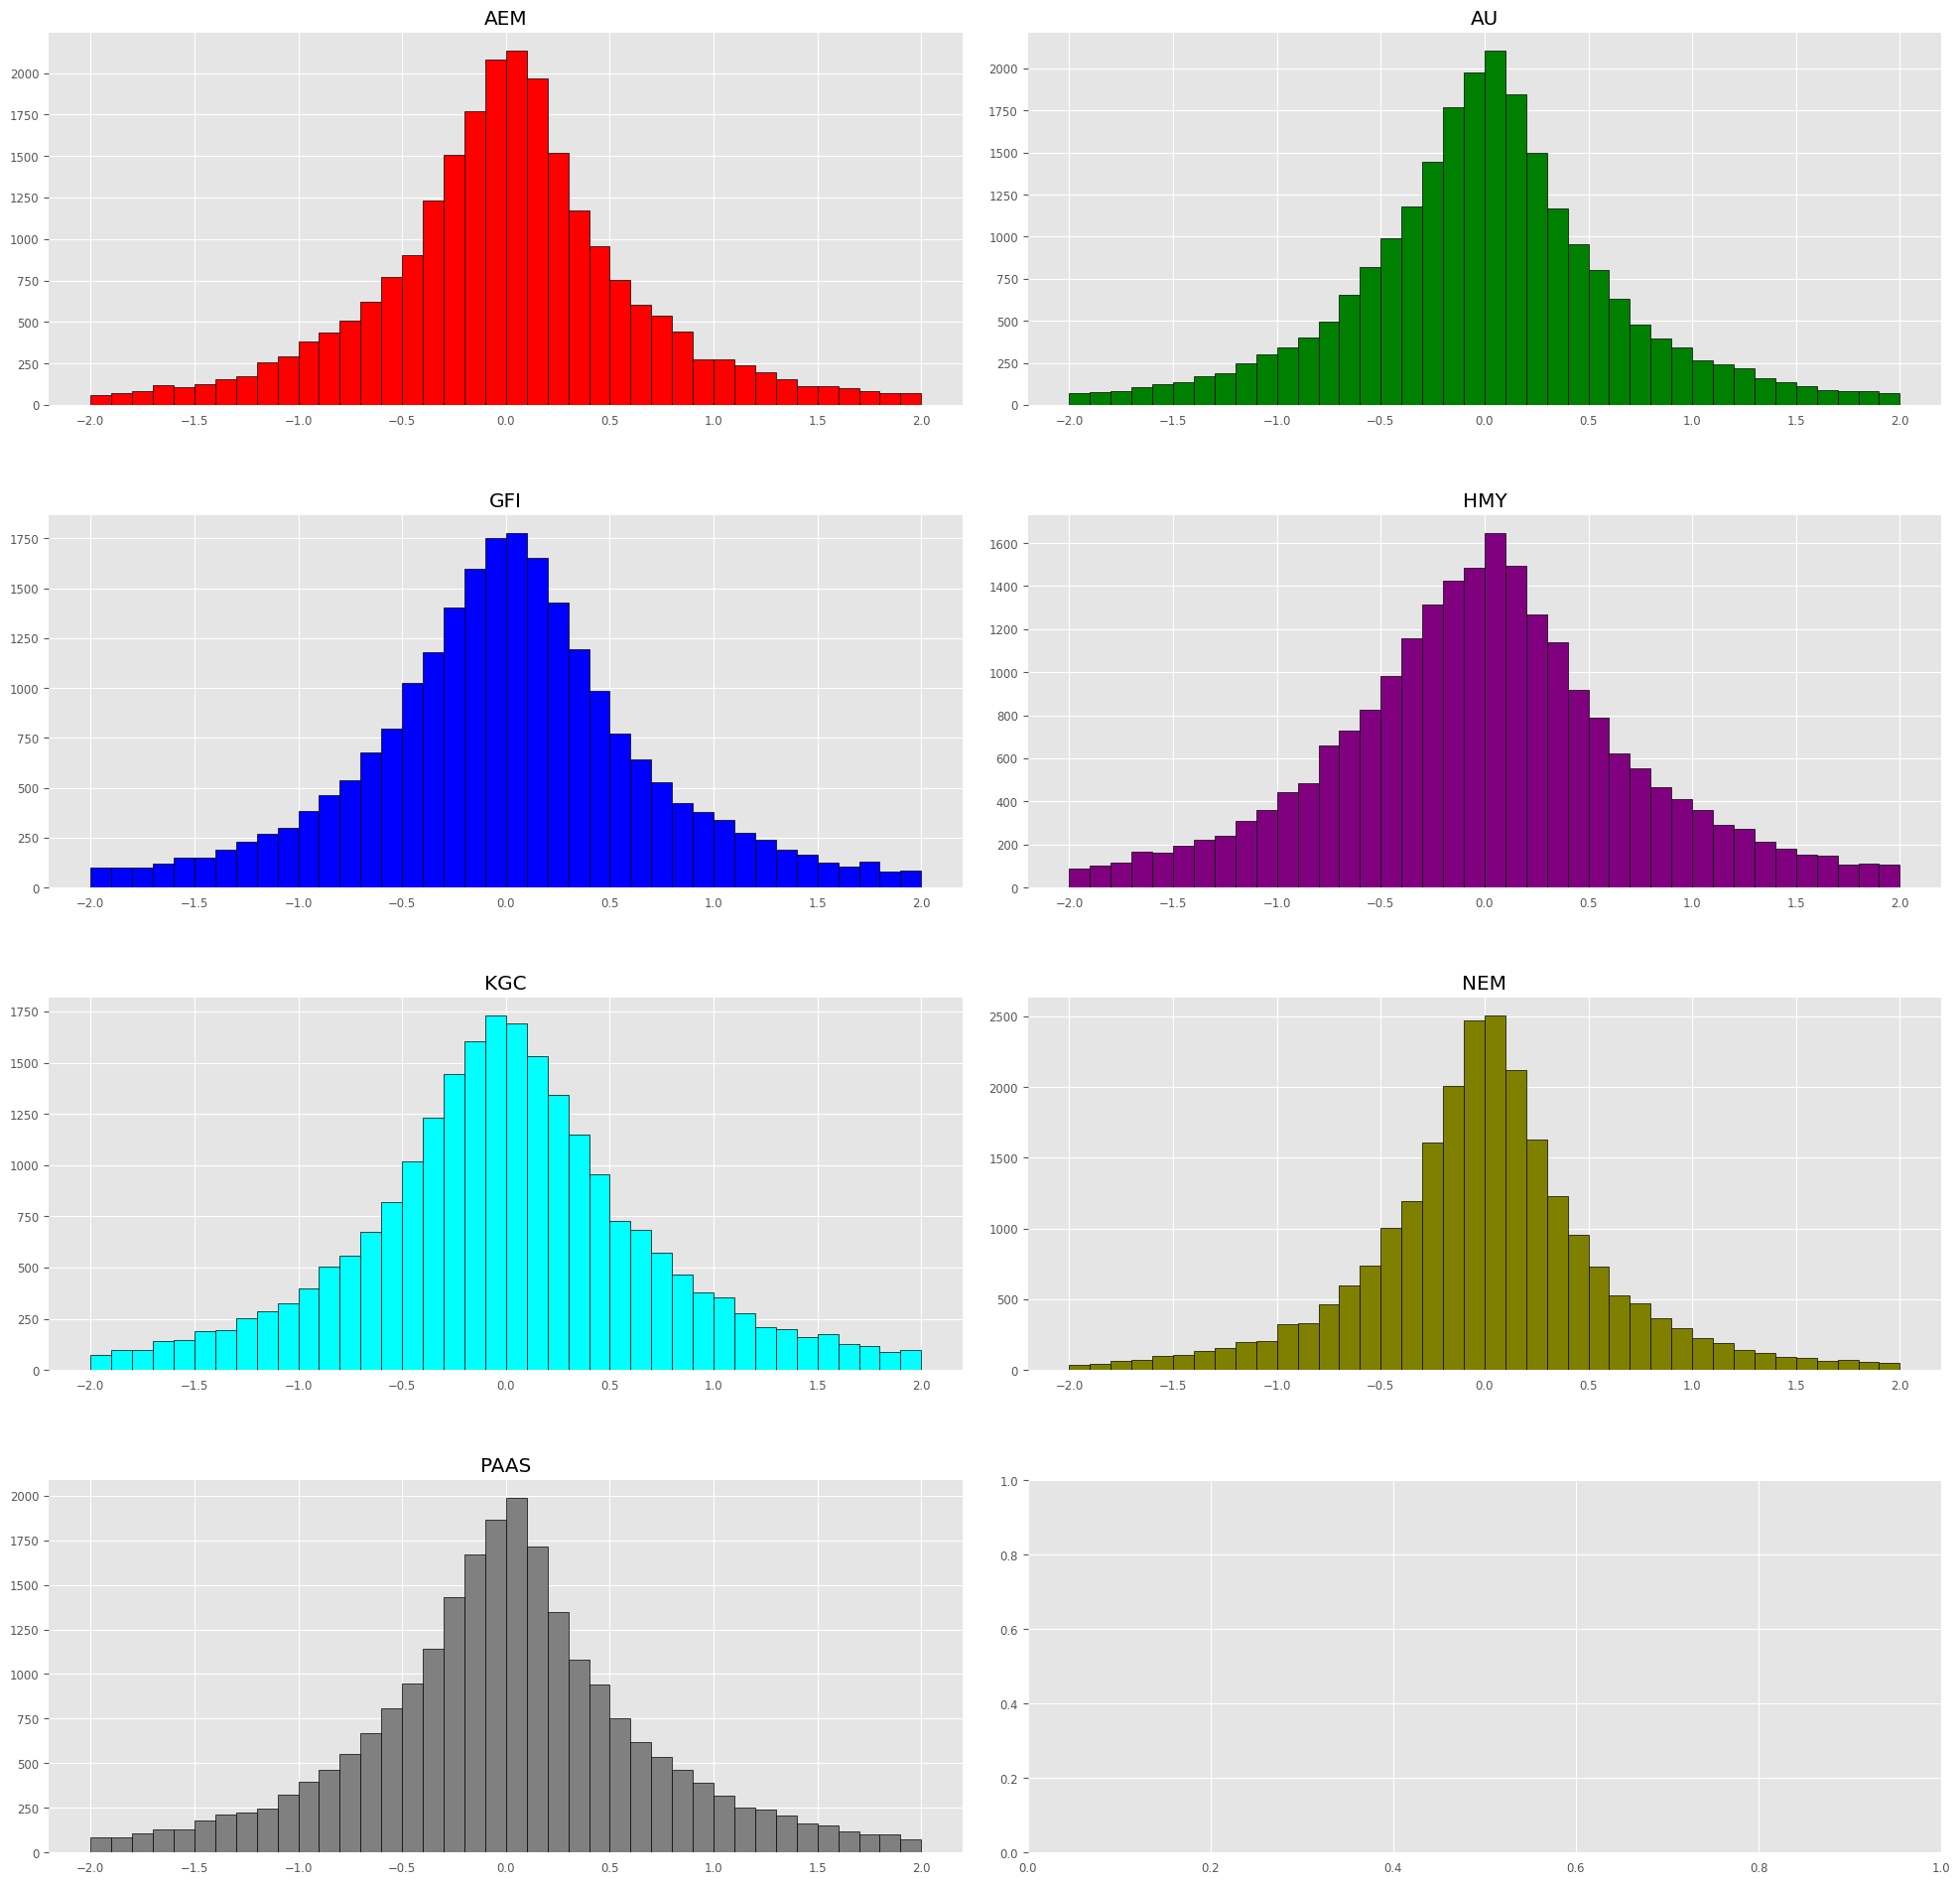

In [6]:
# Dystrybucja zmian w cenie
bins= [x/10  for x in range(-20,21)]
figure, axis = plt.subplots(4, 2)
figure.tight_layout(pad=2.0)

figure.set_figheight(20)
for idx,ticker in enumerate(df):
    axis[idx // 2, idx % 2].hist(df[ticker], bins= bins, color=COLORS[idx], edgecolor='black')
    axis[idx // 2, idx % 2].set_title(ticker)

plt.show()

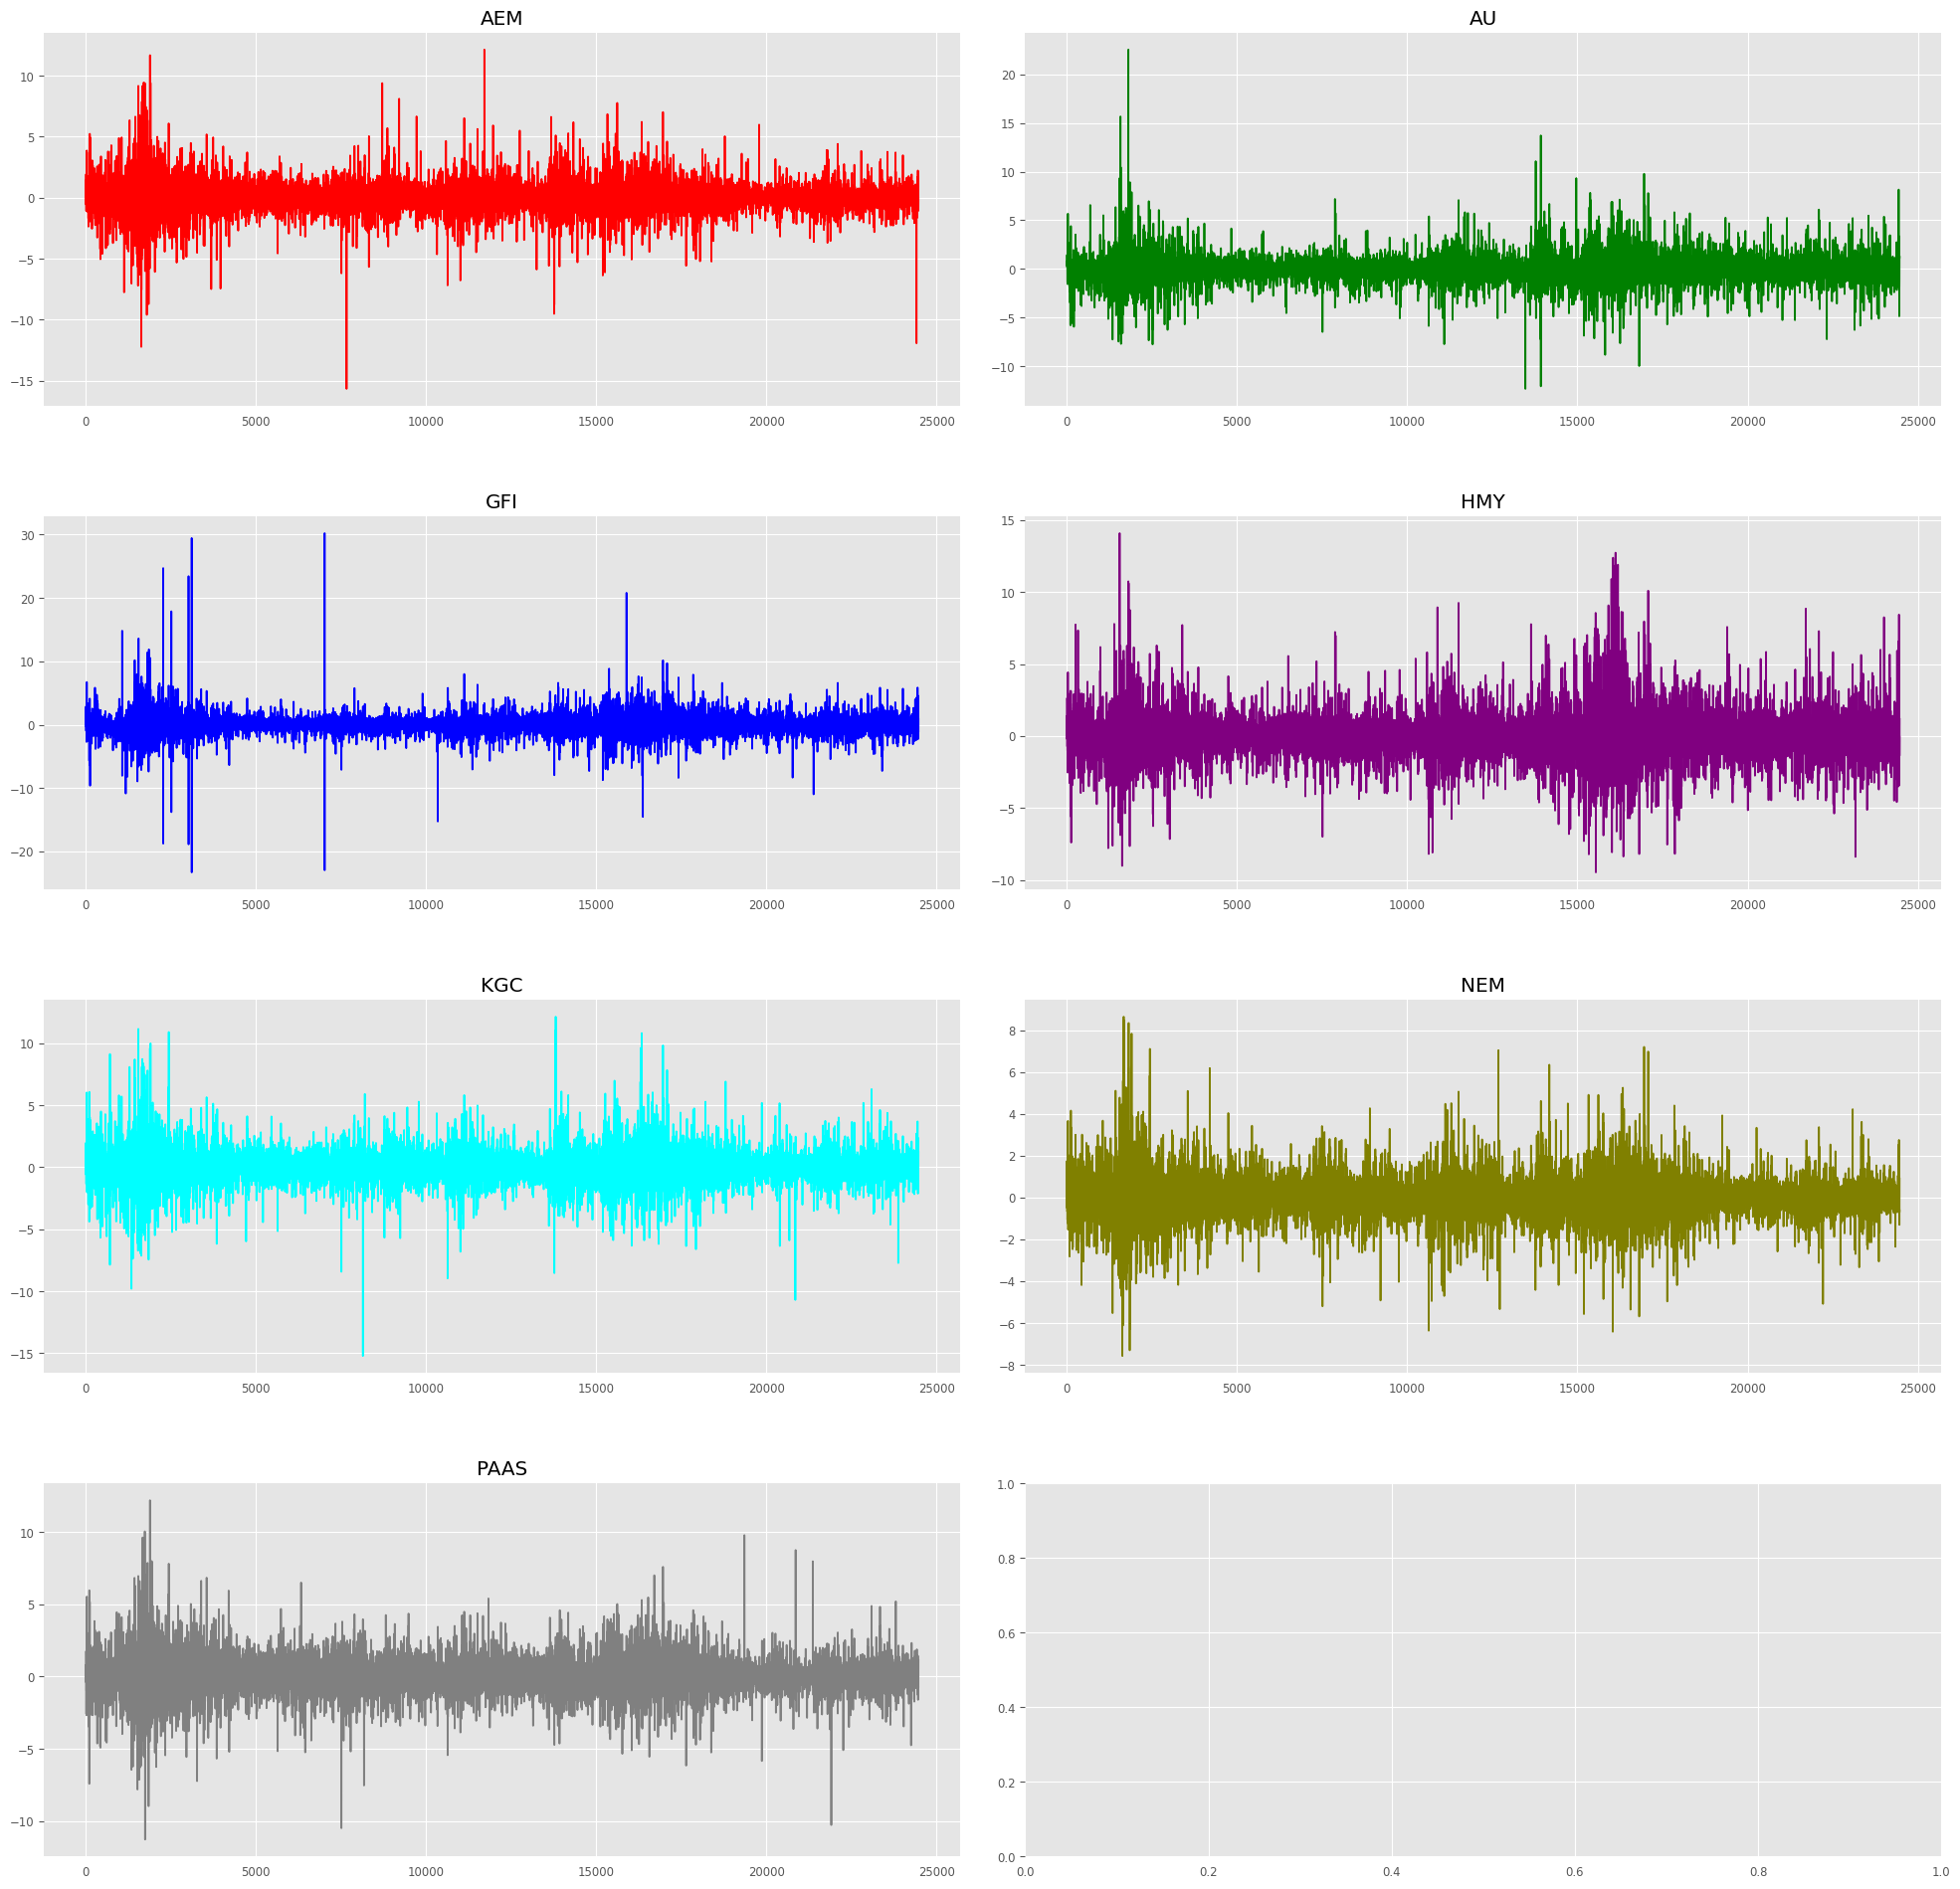

In [7]:
figure, axis = plt.subplots(4, 2)
figure.tight_layout(pad=2.0)
figure.set_figheight(20)
for idx,ticker in enumerate(df):
    axis[idx // 2, idx % 2].plot(df[ticker], color=COLORS[idx])
    axis[idx // 2, idx % 2].set_title(ticker)

plt.show()

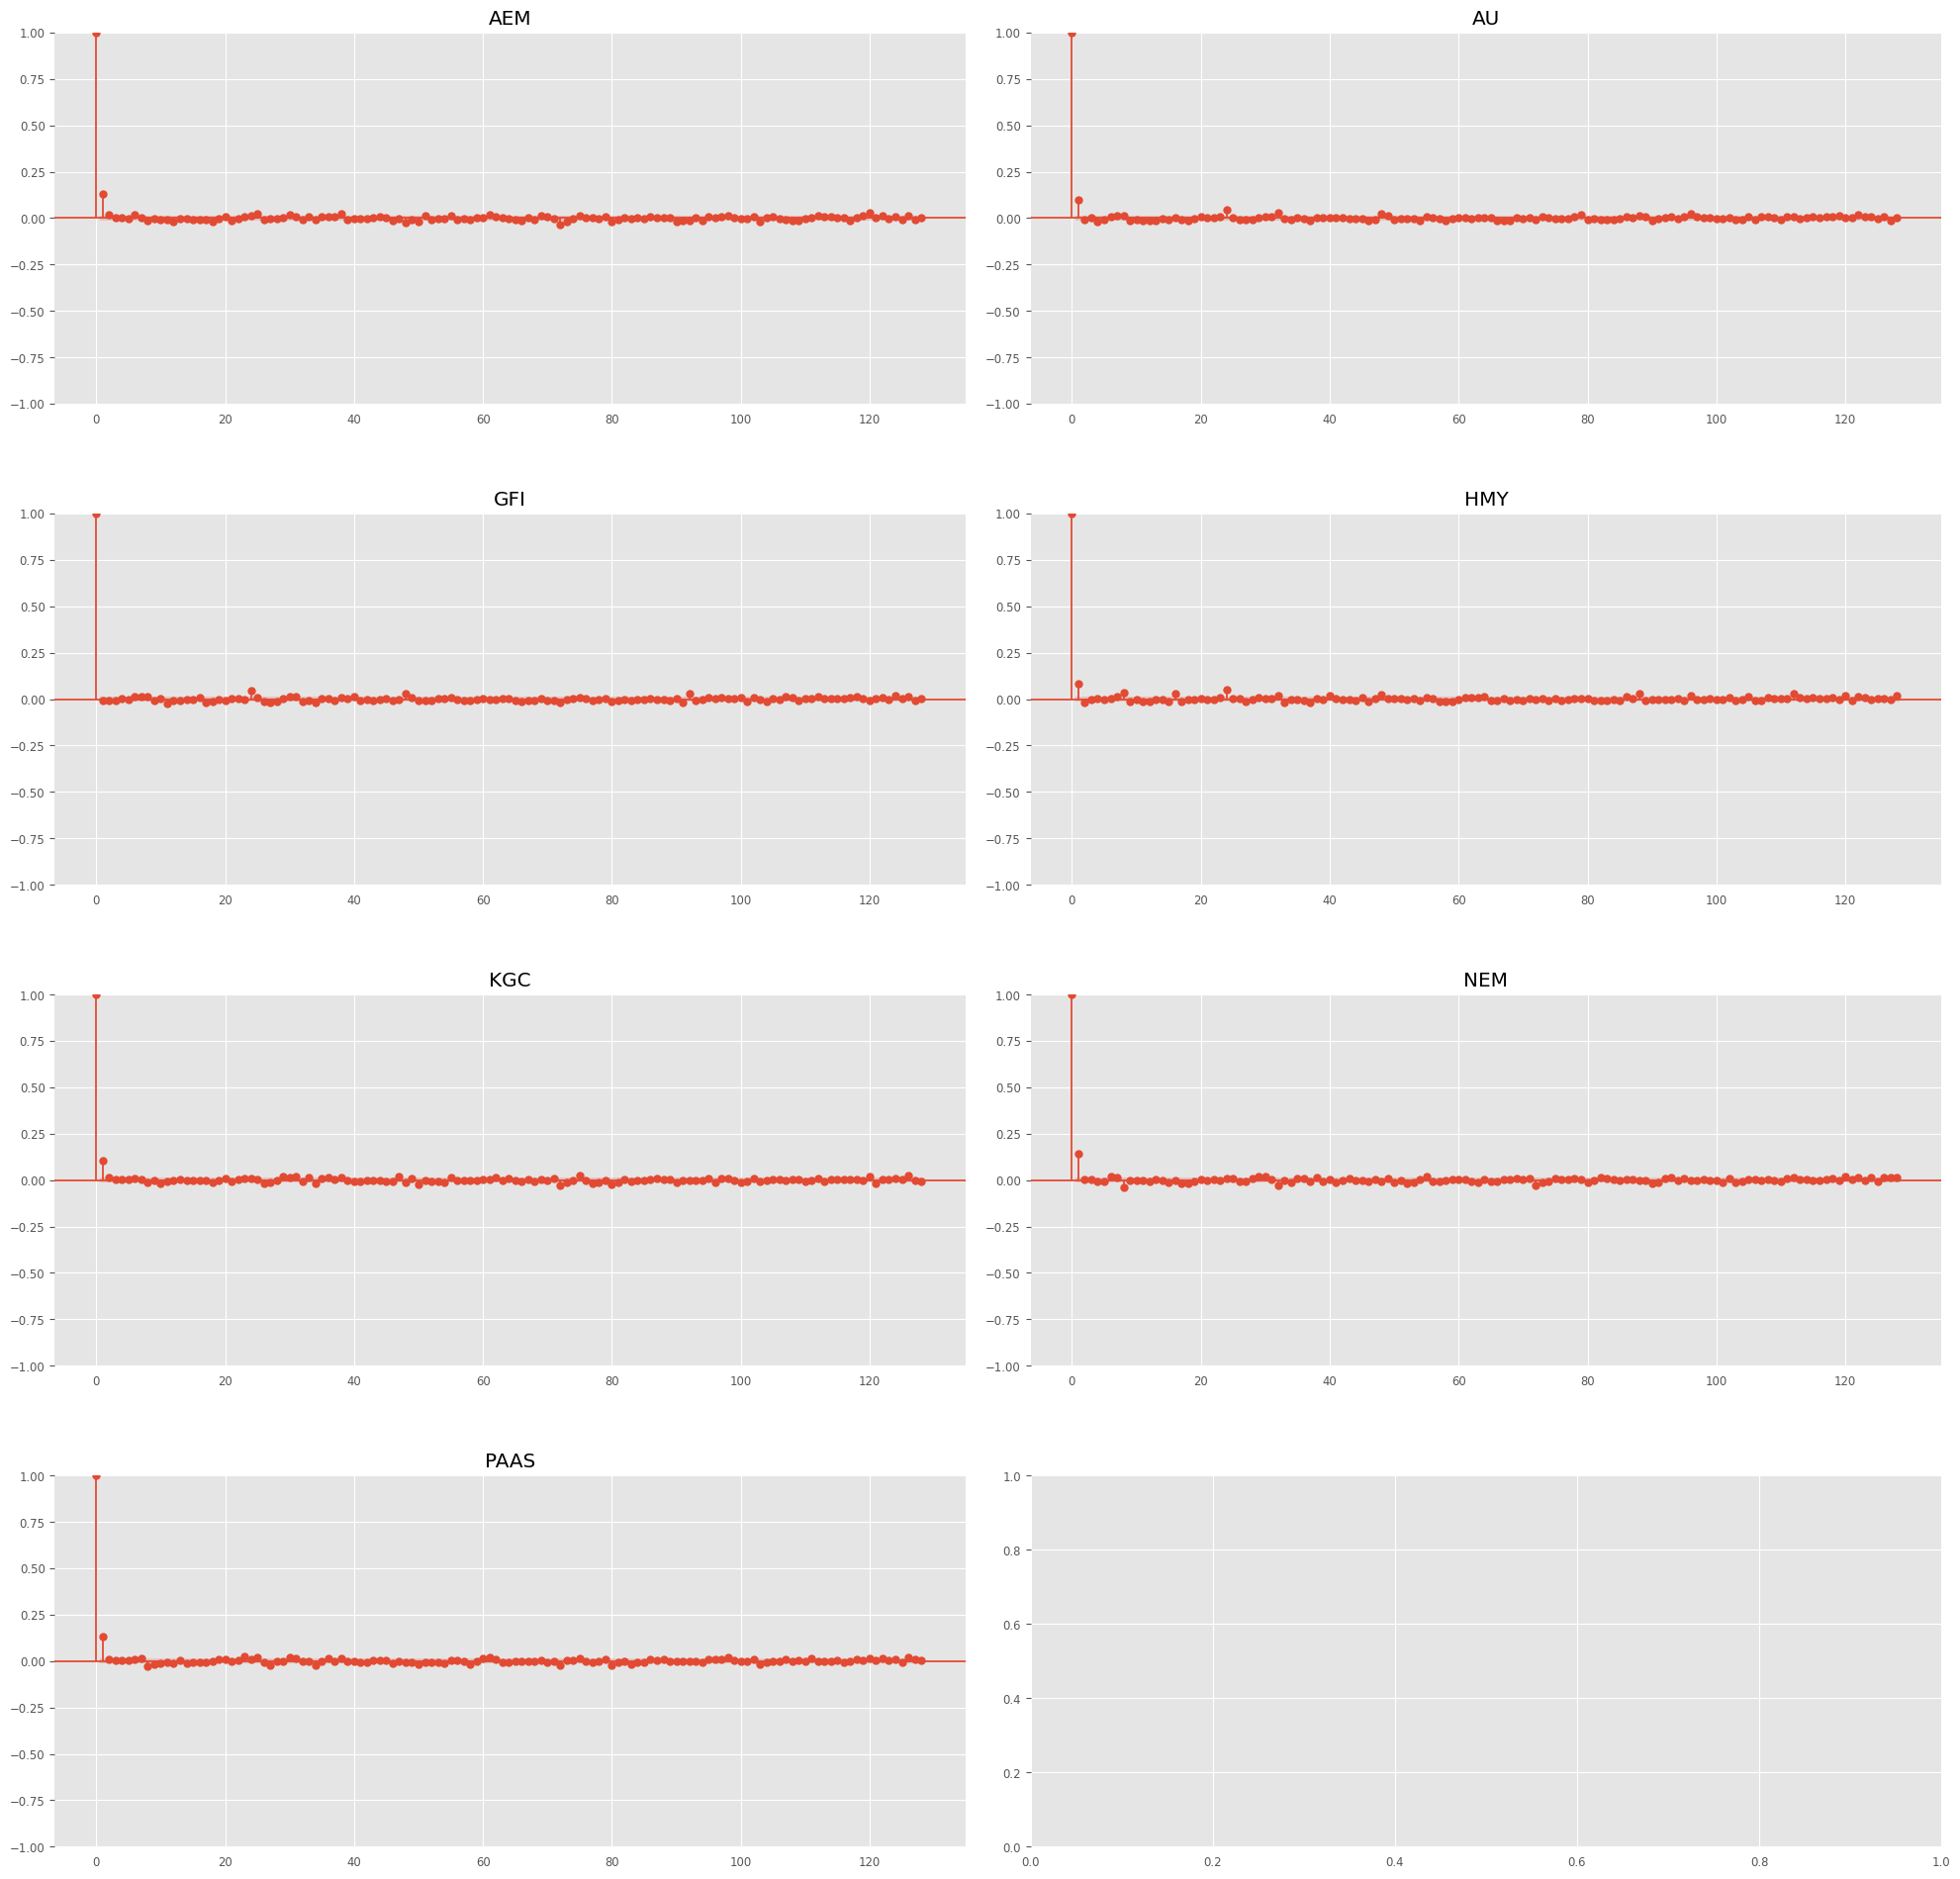

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_from_df(df):
    figure, axis = plt.subplots(4, 2)
    figure.tight_layout(pad=2.0)
    figure.set_figheight(20)
    for idx, ticker in enumerate(df):
        plot_acf(ax= axis[idx // 2, idx % 2],x = df[ticker], lags=128, title=ticker)
    plt.show()

plot_acf_from_df(df)

In [9]:
import darts.utils.statistics as statistics
# Stationary 
stats_df = pd.DataFrame({ CONST.FEATURES.PRICE: [] })
p_threshold = 0.05
def test_stationarity(timeseries: TimeSeries):
    return statistics.stationarity_test_adf(TimeSeries.from_series(timeseries))[1]

for idx,ticker in enumerate(df):
    price_stationarity = test_stationarity(df[ticker])
    stats_df.loc[ticker] = price_stationarity

print(stats_df)
print(stats_df < p_threshold)

      price
AEM     0.0
AU      0.0
GFI     0.0
HMY     0.0
KGC     0.0
NEM     0.0
PAAS    0.0
      price
AEM    True
AU     True
GFI    True
HMY    True
KGC    True
NEM    True
PAAS   True


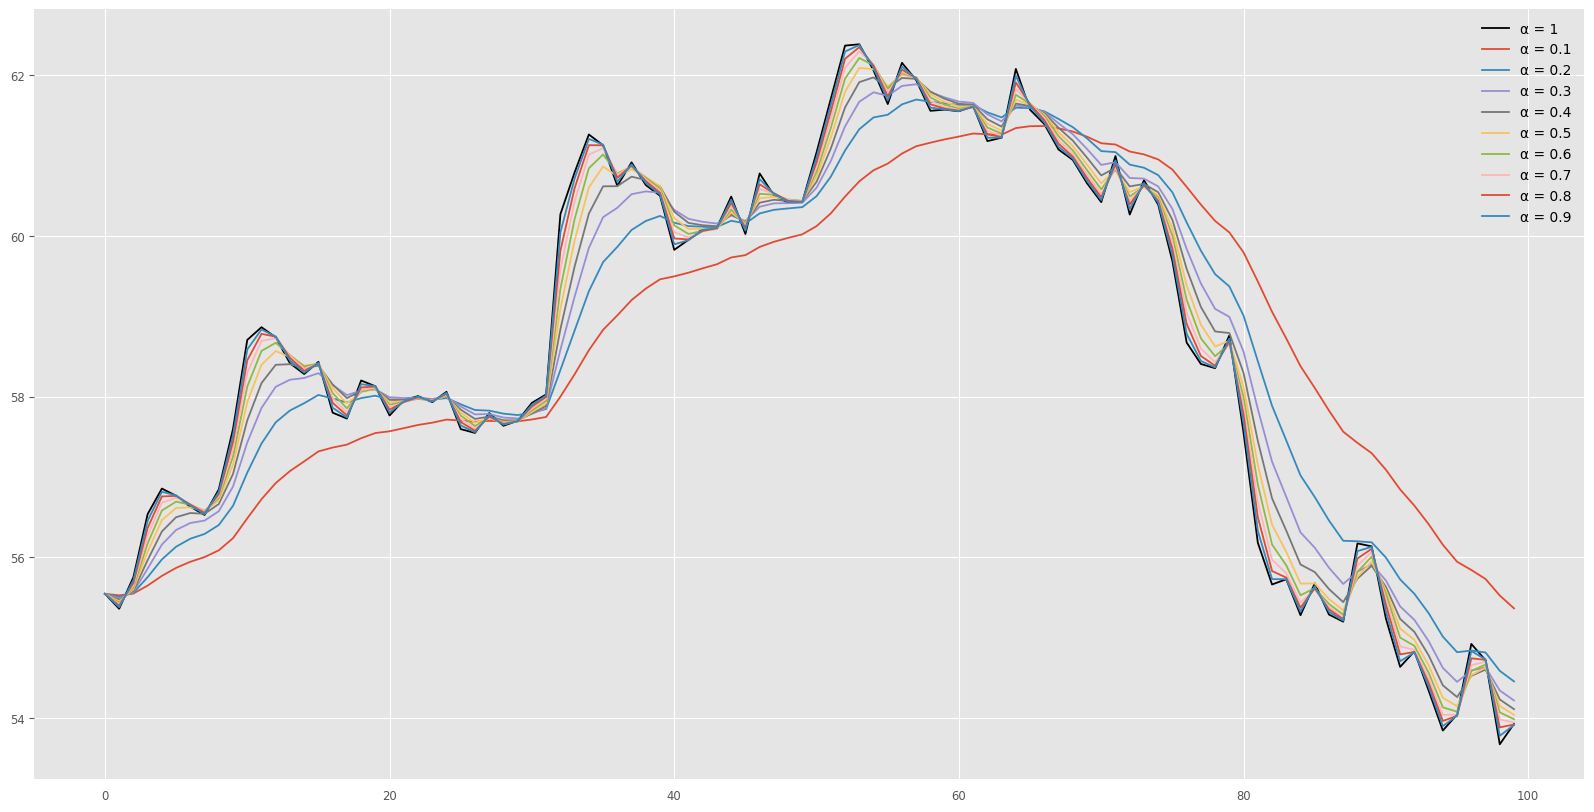

In [13]:
from smoothing import smooth


series = ds.original.series[0][0:100]
plt.plot(range(0,100), series.values(), label=f"α = {1}", color="black")
for i in range (1,10):
    alpha = i / 10
    smoothed = smooth(series, alpha)
    plt.plot(range(0,100), smoothed.values(), label=f"α = {alpha}")


plt.legend(loc="upper right")
plt.show()

In [15]:
cov_df = ds.covariates.train[0].pd_dataframe()
cov_df

component,shares,month_sin,month_cos,weekday_sin,weekday_cos,hour,gold
timestamp,,,,,,,
2008-01-02 09:00:00,-0.071330,0.500000,0.866025,0.974928,-0.222521,0.000000,0.590415
2008-01-02 10:00:00,0.481883,0.500000,0.866025,0.974928,-0.222521,0.142857,0.594324
2008-01-02 11:00:00,0.650179,0.500000,0.866025,0.974928,-0.222521,0.285714,0.597897
2008-01-02 12:00:00,-0.216984,0.500000,0.866025,0.974928,-0.222521,0.428571,0.608824
2008-01-02 13:00:00,-0.259389,0.500000,0.866025,0.974928,-0.222521,0.571429,0.592956
...,...,...,...,...,...,...,...
2020-02-25 15:00:00,0.867409,0.866025,0.500000,0.781832,0.623490,0.857143,0.547303
2020-02-25 16:00:00,0.029852,0.866025,0.500000,0.781832,0.623490,1.000000,0.587182
2020-02-26 09:00:00,-0.599493,0.866025,0.500000,0.974928,-0.222521,0.000000,0.592103


In [16]:
cov_df.describe()

component,shares,month_sin,month_cos,weekday_sin,weekday_cos,hour,gold
count,24467.000000,2.446700e+04,2.446700e+04,24467.000000,24467.000000,24467.000000,24467.000000
mean,-0.071316,-1.227472e-03,-1.693225e-03,0.360956,-0.091991,0.499956,0.590812
std,1.140744,7.072574e-01,7.069819e-01,0.515619,0.771635,0.327340,0.033280
min,-13.060532,-1.000000e+00,-1.000000e+00,-0.433884,-0.900969,0.000000,0.000000
25%,-0.420502,-8.660254e-01,-8.660254e-01,0.000000,-0.900969,0.142857,0.577479
50%,0.000000,1.224647e-16,6.123234e-17,0.433884,-0.222521,0.428571,0.590981
75%,0.579498,5.000000e-01,5.000000e-01,0.781832,0.623490,0.714286,0.604639
max,12.951614,1.000000e+00,1.000000e+00,0.974928,1.000000,1.000000,1.000000


In [17]:
df_dict = {}
for x,ticker in zip(ds.transformed.train, CONST.TICKERS):
    df_dict[ticker] = x.pd_series()
df_targets = pd.DataFrame.from_dict(df_dict)
df_targets

,AEM,AU,GFI,HMY,KGC,NEM,PAAS
timestamp,,,,,,,
2008-01-02 09:00:00,0.651079,0.495379,0.332592,0.463257,0.485457,0.540833,0.569771
2008-01-02 10:00:00,0.637204,0.515254,0.366969,0.478309,0.542751,0.581469,0.668360
2008-01-02 11:00:00,0.673534,0.531381,0.369573,0.541988,0.610855,0.673404,0.647838
2008-01-02 12:00:00,0.721039,0.568477,0.371163,0.509054,0.626071,0.726855,0.620142
2008-01-02 13:00:00,0.709921,0.557444,0.358408,0.519878,0.609572,0.672960,0.604901
...,...,...,...,...,...,...,...
2020-02-25 15:00:00,0.611075,0.431270,0.304676,0.439652,0.454875,0.429011,0.510403
2020-02-25 16:00:00,0.596826,0.431144,0.307261,0.451389,0.454345,0.447369,0.514142
2020-02-26 09:00:00,0.594581,0.508819,0.342755,0.481971,0.479867,0.448077,0.514793


In [18]:
df_targets.describe()

,AEM,AU,GFI,HMY,KGC,NEM,PAAS
count,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000
mean,0.651053,0.495077,0.332492,0.463004,0.485180,0.540828,0.569619
std,0.039487,0.045965,0.018879,0.043878,0.037155,0.048604,0.038553
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.635408,0.478945,0.326634,0.449973,0.476497,0.520533,0.555245
50%,0.651195,0.495053,0.332552,0.462835,0.485126,0.540917,0.569410
75%,0.667041,0.511252,0.338398,0.475786,0.494051,0.560878,0.584300
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


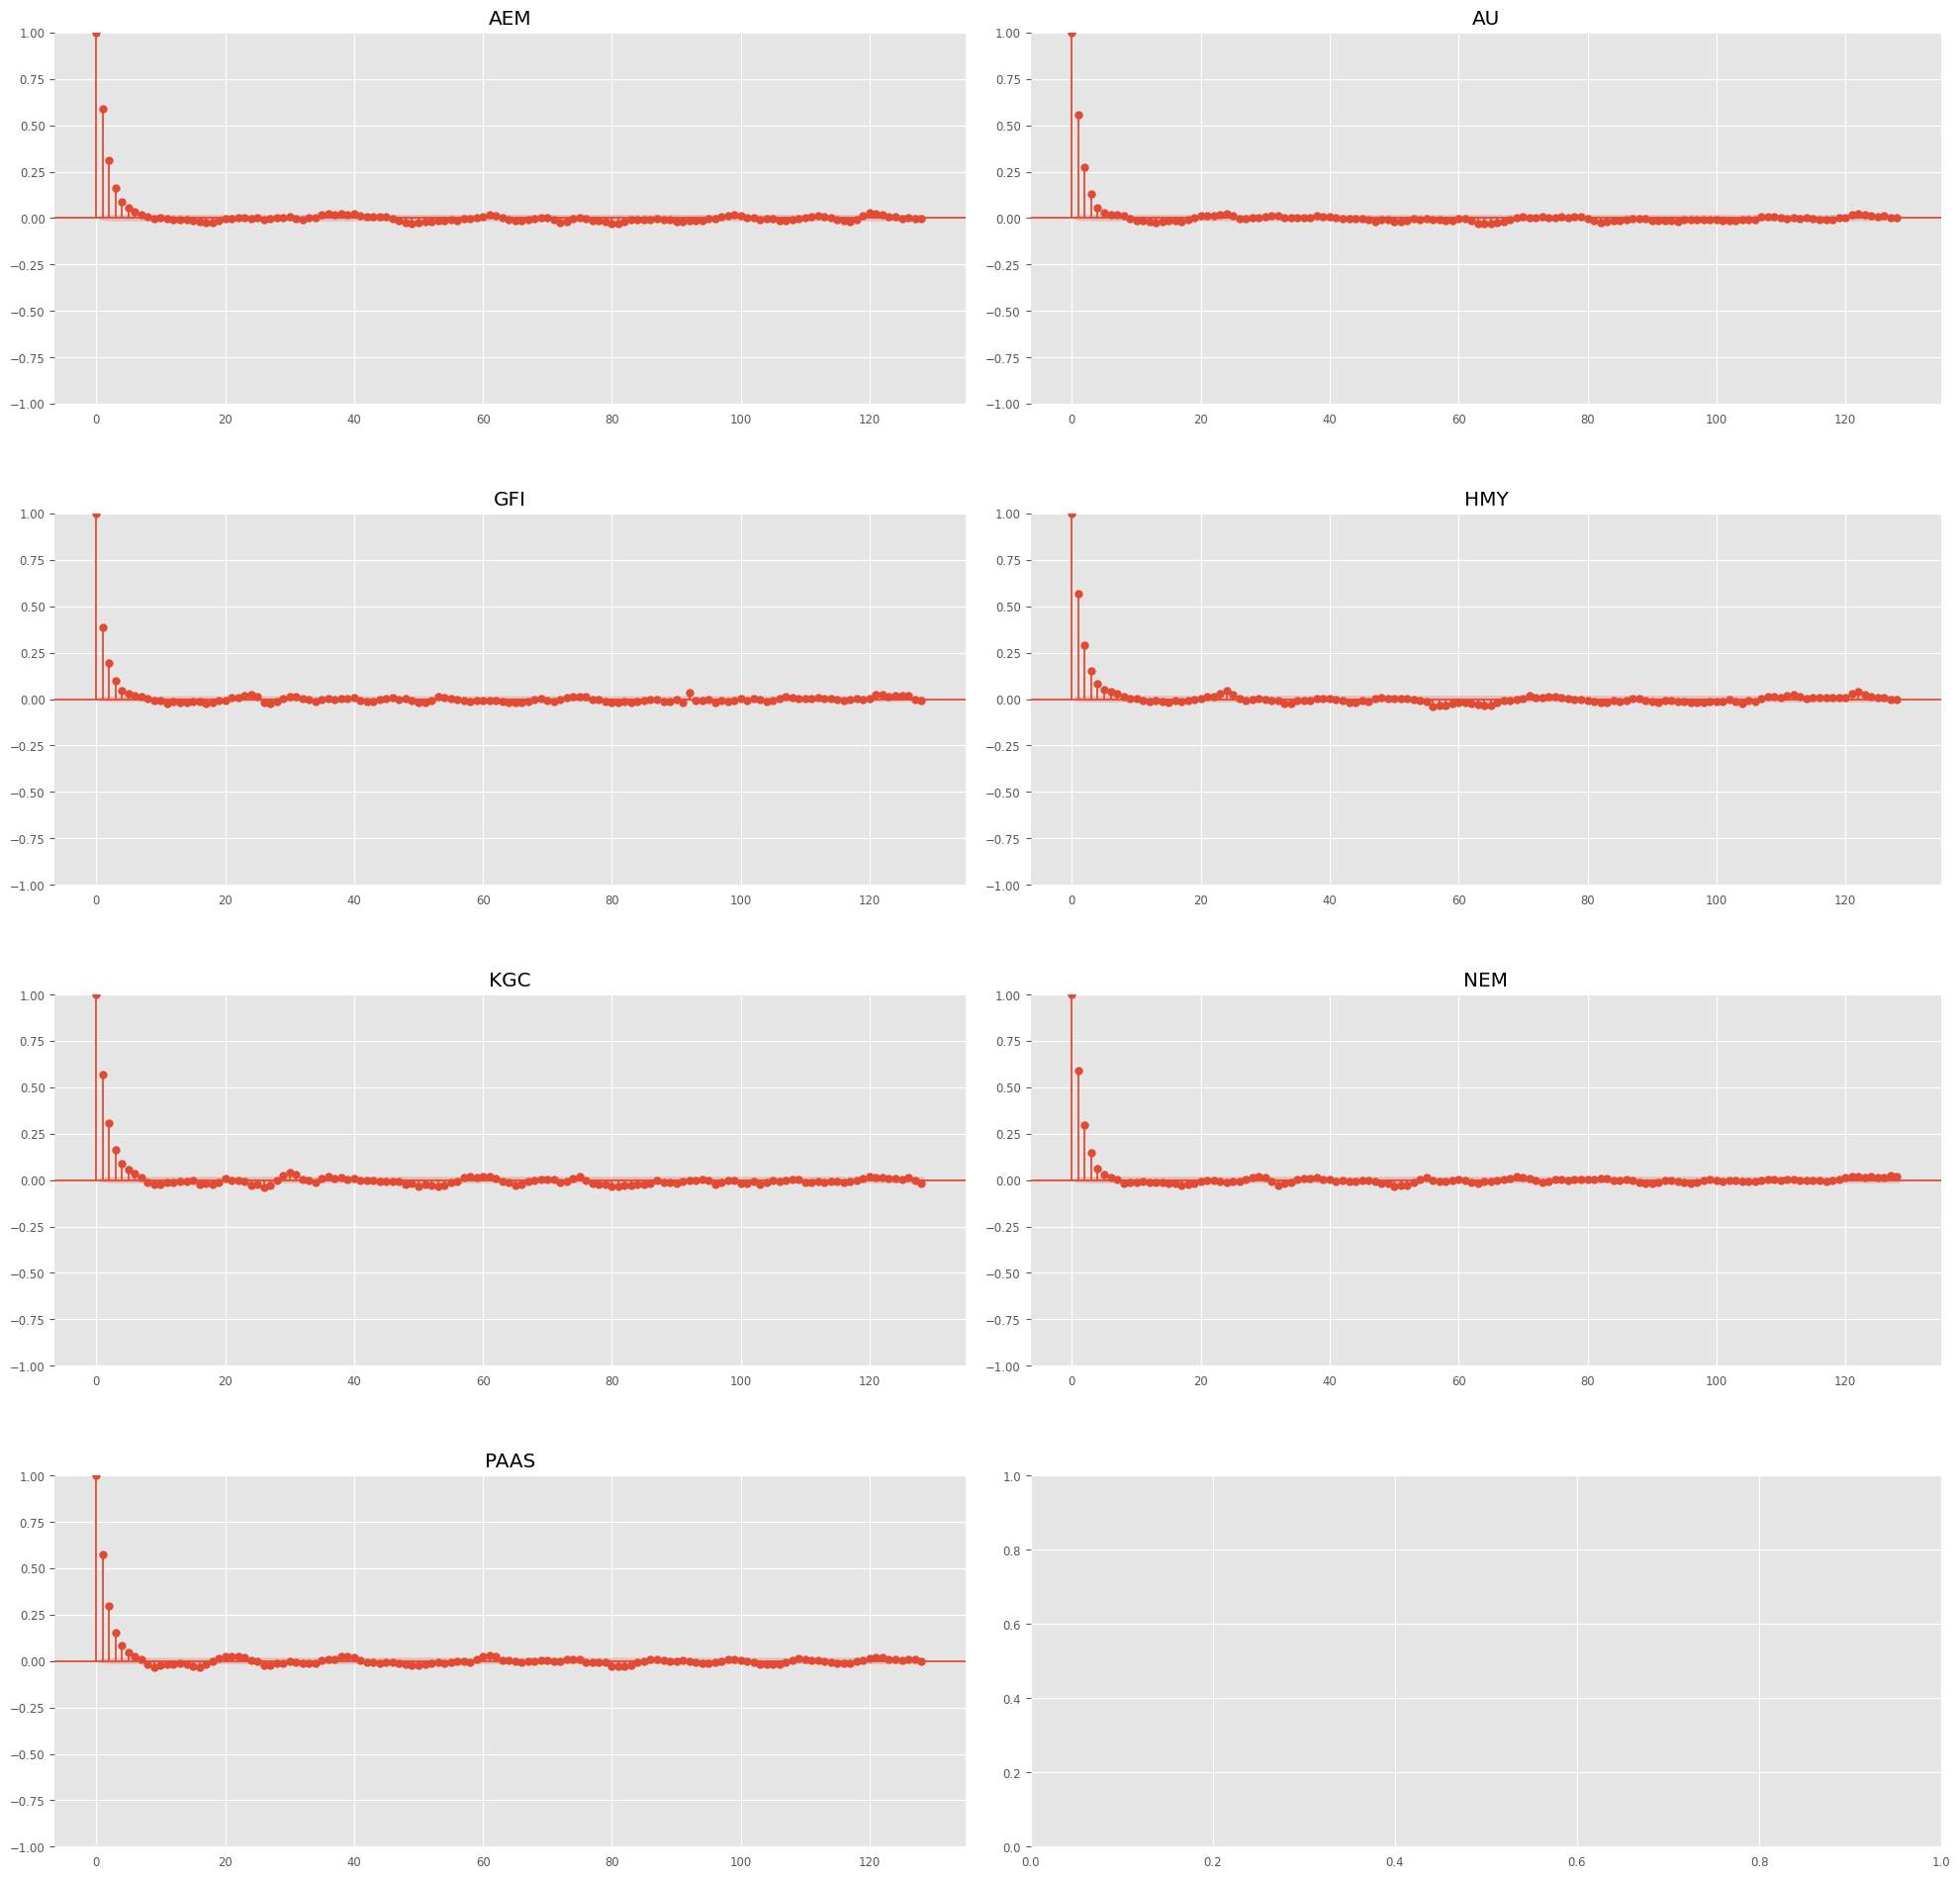

In [19]:
plot_acf_from_df(df_targets)

In [20]:
df_dict = {}
for x,ticker in zip(ds.original.test, CONST.TICKERS):
    df_dict[ticker] = x.pd_series()
df_test = pd.DataFrame.from_dict(df_dict)
(df_test.pct_change() * 100).describe()

,AEM,AU,GFI,HMY,KGC,NEM,PAAS
count,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000
mean,-0.004959,0.004531,0.005284,-0.000403,-0.014235,-0.008144,-0.012874
std,0.791838,0.967794,1.104444,1.194610,0.916454,0.698931,0.936144
min,-8.129912,-7.326144,-18.993027,-8.147133,-8.199615,-6.077117,-11.036998
25%,-0.333446,-0.343472,-0.374505,-0.484456,-0.416504,-0.290009,-0.404839
50%,-0.017658,0.003672,-0.003654,-0.021198,-0.020438,0.000715,0.000083
75%,0.322300,0.350043,0.377768,0.442255,0.381452,0.281879,0.378850
max,7.414198,7.824147,15.897810,9.286952,8.004797,5.828190,6.791008
